C:\Users\samhi\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


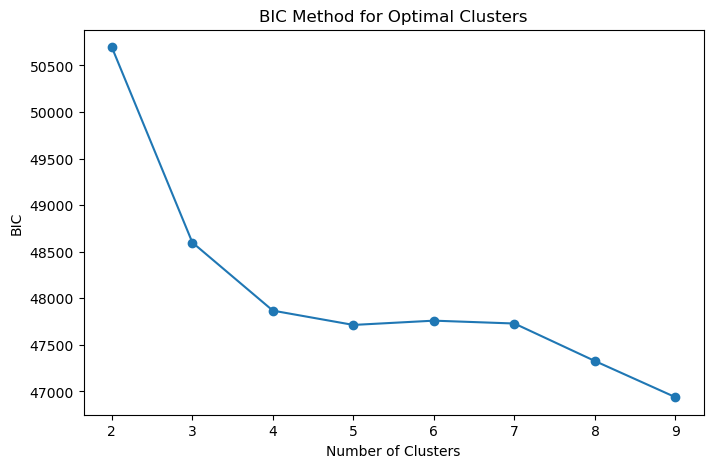

Training Data Metrics:
Silhouette Score: 0.60
Calinski-Harabasz Index: 18353.69
Davies-Bouldin Index: 0.63
Rand Index: 0.66
Adjusted Rand Index: 0.16
Mutual Information: 0.31
V-Measure: 0.23

Test Data Metrics:
Silhouette Score: 0.61
Calinski-Harabasz Index: 4903.88
Davies-Bouldin Index: 0.62
Rand Index: 0.67
Adjusted Rand Index: 0.17
Mutual Information: 0.33
V-Measure: 0.24


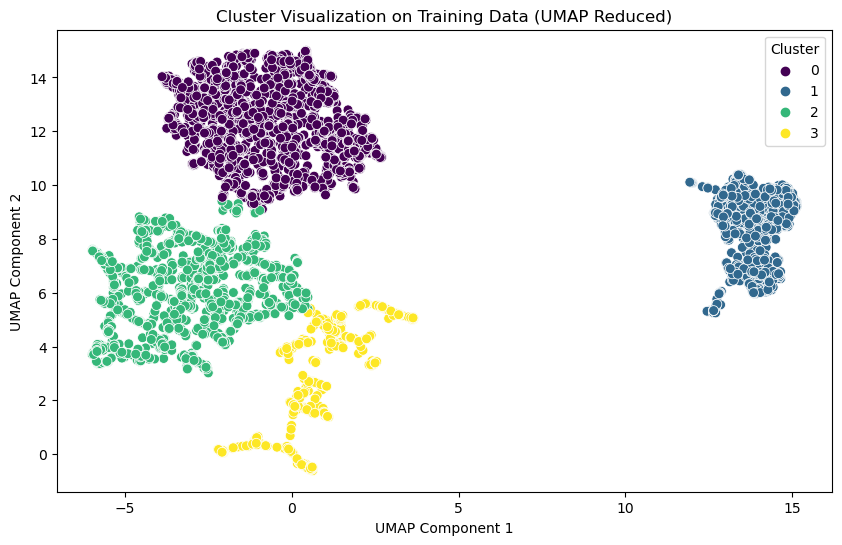

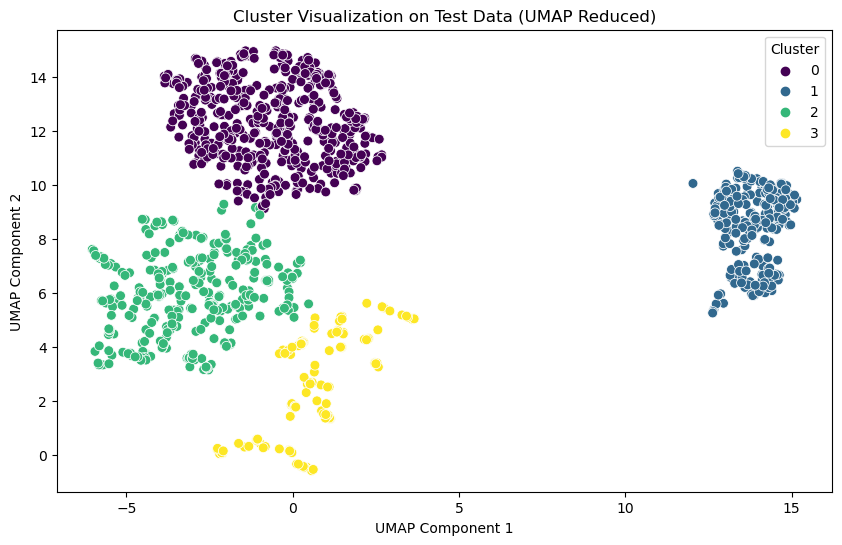

In [2]:
from sklearn.metrics import rand_score, adjusted_rand_score, mutual_info_score, v_measure_score
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import umap

# Load the dataset
data = pd.read_csv('cleaned_train.csv')

# Step 1: Filter out "Adult" category
data = data[data['age_group'] != 'Adult']

# Step 2: Ordinal encode the 'age_group' column
ordinal_encoder = OrdinalEncoder(categories=[['Child', 'Early Teen', 'Teen', 'Young Adult']])
data['age_group'] = ordinal_encoder.fit_transform(data[['age_group']])

# Drop unnecessary columns
columns_to_drop = ['id', 'sii']  # Remove unnecessary columns
data_numeric = data.drop(columns=columns_to_drop, axis=1)

# Split into features and target
X = data_numeric
y = data['sii']  # Use 'sii' for oversampling

# Step 3: Apply ADASYN for Oversampling
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Step 4: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Step 5: UMAP for Dimensionality Reduction
umap_model = umap.UMAP(n_components=2, random_state=42)  # Reduce to 2 components
X_train_umap = umap_model.fit_transform(X_train)
X_test_umap = umap_model.transform(X_test)  # Apply the same transformation to test data

# Step 6: Determine Optimal Clusters using the Bayesian Information Criterion (BIC)
bic = []
k_range = range(2, 10)
for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_train_umap)
    bic.append(gmm.bic(X_train_umap))

# Plot the BIC Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, bic, marker='o')
plt.title('BIC Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')
plt.show()

# Optimal number of clusters based on BIC
optimal_k = 4  # Set based on the BIC plot
gmm = GaussianMixture(n_components=optimal_k, random_state=42)

# Step 7: Fit GMM on Training Data
gmm.fit(X_train_umap)
train_clusters = gmm.predict(X_train_umap)
test_clusters = gmm.predict(X_test_umap)

# Step 8: Evaluate Clustering Performance
# Metrics for Training Data
train_silhouette = silhouette_score(X_train_umap, train_clusters)
train_calinski_harabasz = calinski_harabasz_score(X_train_umap, train_clusters)
train_davies_bouldin = davies_bouldin_score(X_train_umap, train_clusters)

# Rand Index and Adjusted Rand Index for Training Data
train_rand_index = rand_score(y_train, train_clusters)
train_adjusted_rand_index = adjusted_rand_score(y_train, train_clusters)

# Mutual Information and V-Measure for Training Data
train_mutual_info = mutual_info_score(y_train, train_clusters)
train_v_measure = v_measure_score(y_train, train_clusters)

# Metrics for Test Data
test_silhouette = silhouette_score(X_test_umap, test_clusters)
test_calinski_harabasz = calinski_harabasz_score(X_test_umap, test_clusters)
test_davies_bouldin = davies_bouldin_score(X_test_umap, test_clusters)

# Rand Index and Adjusted Rand Index for Test Data
test_rand_index = rand_score(y_test, test_clusters)
test_adjusted_rand_index = adjusted_rand_score(y_test, test_clusters)

# Mutual Information and V-Measure for Test Data
test_mutual_info = mutual_info_score(y_test, test_clusters)
test_v_measure = v_measure_score(y_test, test_clusters)

# Print Training Data Metrics
print(f"Training Data Metrics:")
print(f"Silhouette Score: {train_silhouette:.2f}")
print(f"Calinski-Harabasz Index: {train_calinski_harabasz:.2f}")
print(f"Davies-Bouldin Index: {train_davies_bouldin:.2f}")
print(f"Rand Index: {train_rand_index:.2f}")
print(f"Adjusted Rand Index: {train_adjusted_rand_index:.2f}")
print(f"Mutual Information: {train_mutual_info:.2f}")
print(f"V-Measure: {train_v_measure:.2f}")

# Print Test Data Metrics
print(f"\nTest Data Metrics:")
print(f"Silhouette Score: {test_silhouette:.2f}")
print(f"Calinski-Harabasz Index: {test_calinski_harabasz:.2f}")
print(f"Davies-Bouldin Index: {test_davies_bouldin:.2f}")
print(f"Rand Index: {test_rand_index:.2f}")
print(f"Adjusted Rand Index: {test_adjusted_rand_index:.2f}")
print(f"Mutual Information: {test_mutual_info:.2f}")
print(f"V-Measure: {test_v_measure:.2f}")

# Step 9: Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_umap[:, 0], y=X_train_umap[:, 1], hue=train_clusters, palette='viridis', s=50)
plt.title('Cluster Visualization on Training Data (UMAP Reduced)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_umap[:, 0], y=X_test_umap[:, 1], hue=test_clusters, palette='viridis', s=50)
plt.title('Cluster Visualization on Test Data (UMAP Reduced)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster')
plt.show()

C:\Users\samhi\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Number of clusters found by DBSCAN (excluding noise): 6
Silhouette Score: 0.49
Calinski-Harabasz Index: 10200.70
Davies-Bouldin Index: 0.56


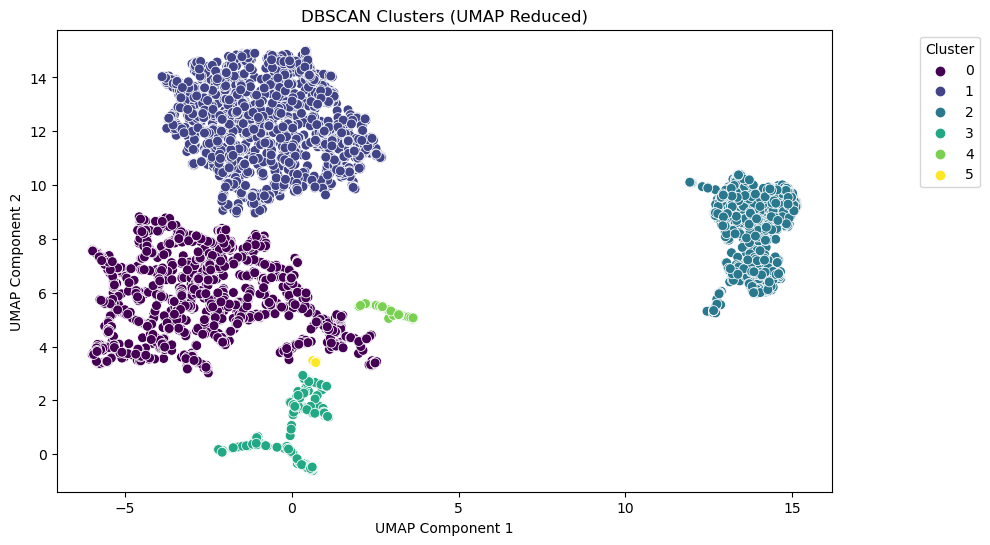

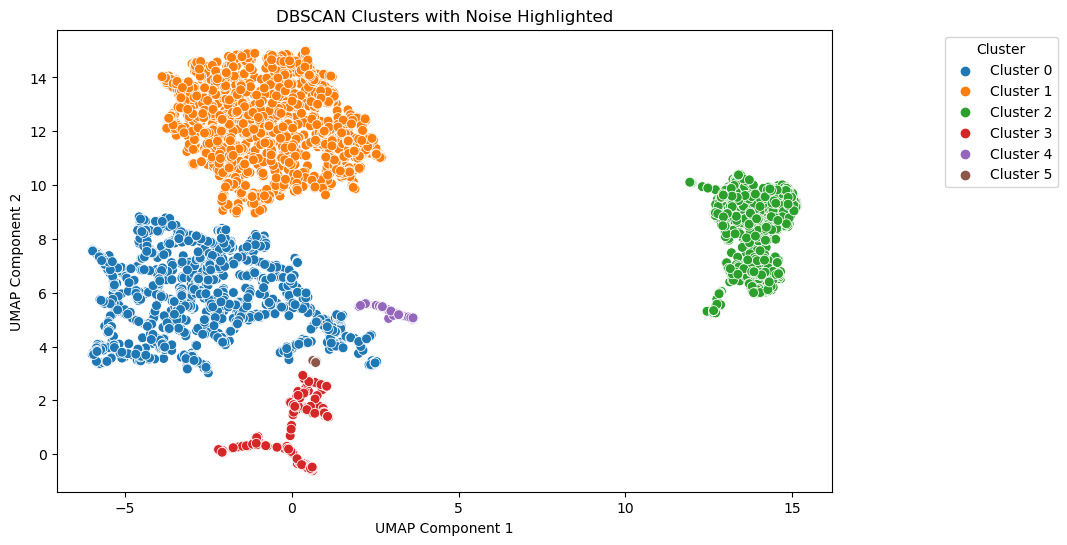

In [4]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('cleaned_train.csv')

# Step 1: Filter out "Adult" category
data = data[data['age_group'] != 'Adult']

# Step 2: Ordinal encode the 'age_group' column
ordinal_encoder = OrdinalEncoder(categories=[['Child', 'Early Teen', 'Teen', 'Young Adult']])
data['age_group'] = ordinal_encoder.fit_transform(data[['age_group']])

# Drop unnecessary columns
columns_to_drop = ['id', 'sii']  # Adjust 'sii' depending on its usage
data_numeric = data.drop(columns=columns_to_drop, axis=1)

# Extract features and target
X = data_numeric
y = data['sii']

# Step 3: Apply ADASYN for Oversampling
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Step 4: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Step 5: Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Step 6: UMAP for Dimensionality Reduction
umap_model = umap.UMAP(n_components=2, random_state=42)  # Reduce to 2 dimensions
X_train_umap = umap_model.fit_transform(X_train)
X_test_umap = umap_model.transform(X_test)

# Step 7: Run DBSCAN with tuned parameters
eps_value = 0.5  # Adjust based on density
min_samples_value = 5  # Minimum core points to form a cluster

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
dbscan_labels = dbscan.fit_predict(X_train_umap)

# Check number of clusters (excluding noise)
unique_labels = set(dbscan_labels)
num_clusters = len(unique_labels) - (1 if -1 in dbscan_labels else 0)
print(f"Number of clusters found by DBSCAN (excluding noise): {num_clusters}")

# Step 8: Evaluate Clustering Performance
if num_clusters > 0:
    silhouette = silhouette_score(X_train_umap, dbscan_labels)
    calinski_harabasz = calinski_harabasz_score(X_train_umap, dbscan_labels)
    davies_bouldin = davies_bouldin_score(X_train_umap, dbscan_labels)

    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz:.2f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.2f}")
else:
    print("No meaningful clusters were found by DBSCAN. Adjust parameters and retry.")

# Step 9: Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_train_umap[:, 0],
    y=X_train_umap[:, 1],
    hue=dbscan_labels,
    palette='viridis',
    s=50,
    legend="full"
)
plt.title('DBSCAN Clusters (UMAP Reduced)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

# Step 10: Visualize Noise Points Separately
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_train_umap[:, 0],
    y=X_train_umap[:, 1],
    hue=["Noise" if label == -1 else f"Cluster {label}" for label in dbscan_labels],
    palette='tab10',
    s=50,
    legend="full"
)
plt.title('DBSCAN Clusters with Noise Highlighted')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()


C:\Users\samhi\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


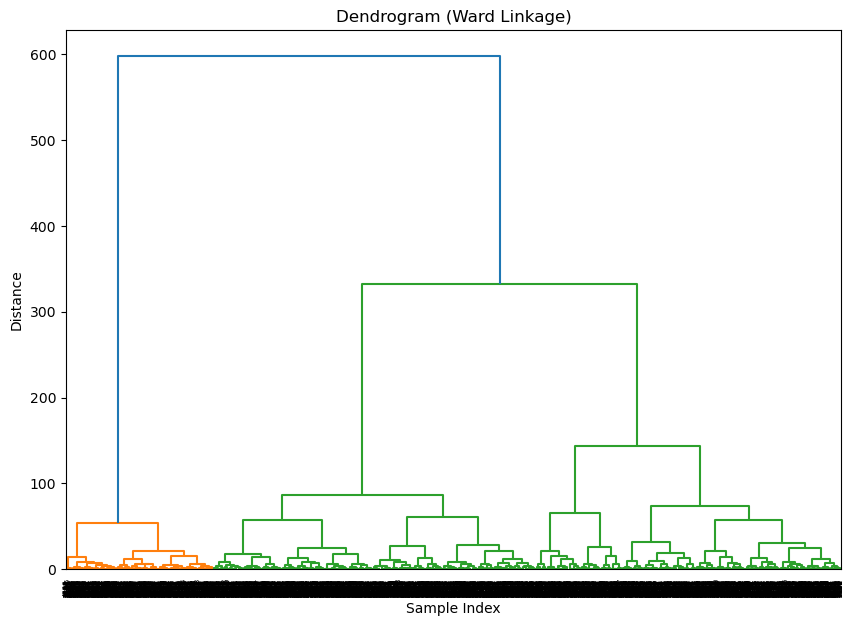

Hierarchical Clustering - Training Data Metrics:
Silhouette Score: 0.60
Calinski-Harabasz Index: 18387.40
Davies-Bouldin Index: 0.63

Hierarchical Clustering - Test Data Metrics:
Silhouette Score: 0.61
Calinski-Harabasz Index: 4909.44
Davies-Bouldin Index: 0.62


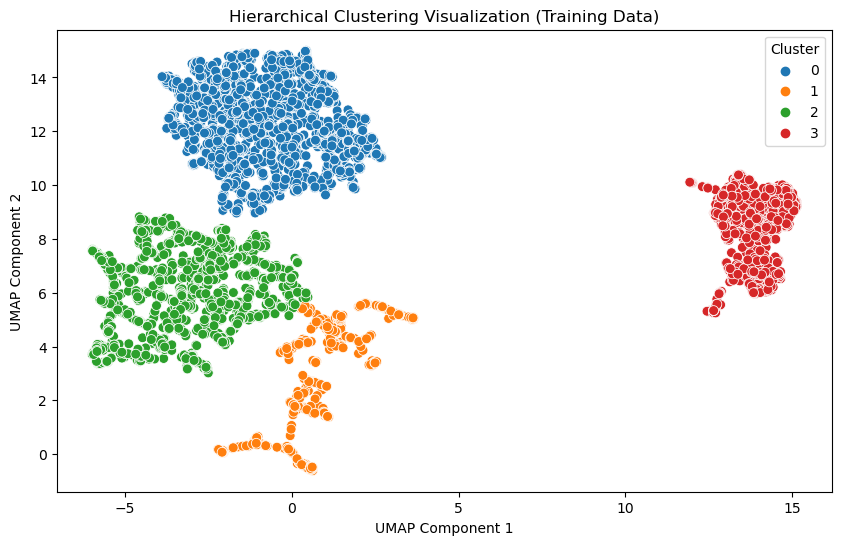

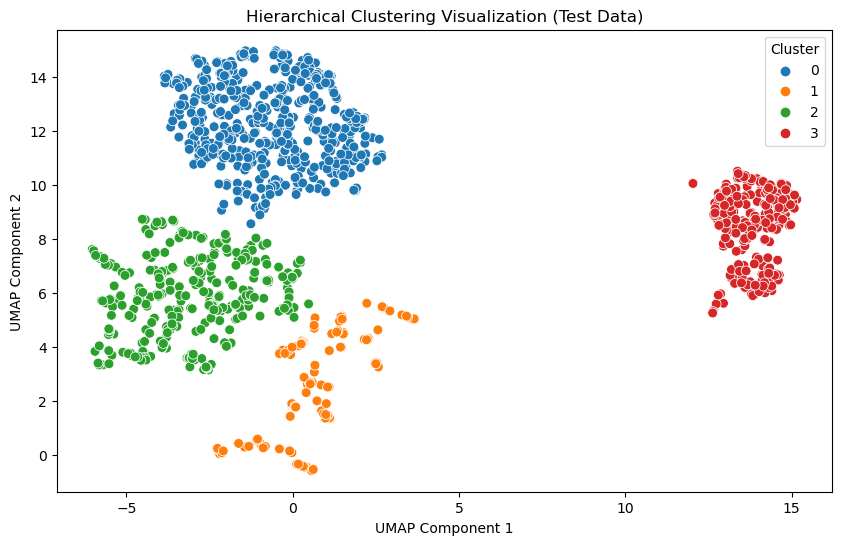

In [5]:
from sklearn.metrics import rand_score, adjusted_rand_score, mutual_info_score, v_measure_score
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import umap

# Load the dataset
data = pd.read_csv('cleaned_train.csv')

# Step 1: Filter out "Adult" category
data = data[data['age_group'] != 'Adult']

# Step 2: Ordinal encode the 'age_group' column
ordinal_encoder = OrdinalEncoder(categories=[['Child', 'Early Teen', 'Teen', 'Young Adult']])
data['age_group'] = ordinal_encoder.fit_transform(data[['age_group']])

# Drop unnecessary columns
columns_to_drop = ['id', 'sii']  # Remove unnecessary columns
data_numeric = data.drop(columns=columns_to_drop, axis=1)

# Split into features and target
X = data_numeric
y = data['sii']  # Use 'sii' for oversampling

# Step 3: Apply ADASYN for Oversampling
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Step 4: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Step 5: UMAP for Dimensionality Reduction
umap_model = umap.UMAP(n_components=2, random_state=42)  # Reduce to 2 components
X_train_umap = umap_model.fit_transform(X_train)
X_test_umap = umap_model.transform(X_test)  # Apply the same transformation to test data

# Step 6: Perform Hierarchical Clustering
# Compute the linkage matrix for dendrogram visualization
linkage_matrix = linkage(X_train_umap, method='ward')  # 'ward' minimizes the variance within clusters

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Dendrogram (Ward Linkage)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Determine the optimal number of clusters visually from the dendrogram or programmatically
optimal_clusters = 4  # You can adjust this based on the dendrogram

# Fit Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=optimal_clusters, affinity='euclidean', linkage='ward')
agg_clusters_train = agg_clustering.fit_predict(X_train_umap)
agg_clusters_test = agg_clustering.fit_predict(X_test_umap)

# Step 7: Evaluate Clustering Performance for Hierarchical Clustering
# Metrics for Training Data
agg_train_silhouette = silhouette_score(X_train_umap, agg_clusters_train)
agg_train_calinski_harabasz = calinski_harabasz_score(X_train_umap, agg_clusters_train)
agg_train_davies_bouldin = davies_bouldin_score(X_train_umap, agg_clusters_train)

# Metrics for Test Data
agg_test_silhouette = silhouette_score(X_test_umap, agg_clusters_test)
agg_test_calinski_harabasz = calinski_harabasz_score(X_test_umap, agg_clusters_test)
agg_test_davies_bouldin = davies_bouldin_score(X_test_umap, agg_clusters_test)

# Print Metrics for Training Data
print(f"Hierarchical Clustering - Training Data Metrics:")
print(f"Silhouette Score: {agg_train_silhouette:.2f}")
print(f"Calinski-Harabasz Index: {agg_train_calinski_harabasz:.2f}")
print(f"Davies-Bouldin Index: {agg_train_davies_bouldin:.2f}")

# Print Metrics for Test Data
print(f"\nHierarchical Clustering - Test Data Metrics:")
print(f"Silhouette Score: {agg_test_silhouette:.2f}")
print(f"Calinski-Harabasz Index: {agg_test_calinski_harabasz:.2f}")
print(f"Davies-Bouldin Index: {agg_test_davies_bouldin:.2f}")

# Step 8: Visualize Clusters for Training and Test Data
# Visualization for Training Data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_umap[:, 0], y=X_train_umap[:, 1], hue=agg_clusters_train, palette='tab10', s=50)
plt.title('Hierarchical Clustering Visualization (Training Data)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster')
plt.show()

# Visualization for Test Data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_umap[:, 0], y=X_test_umap[:, 1], hue=agg_clusters_test, palette='tab10', s=50)
plt.title('Hierarchical Clustering Visualization (Test Data)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster')
plt.show()


C:\Users\samhi\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


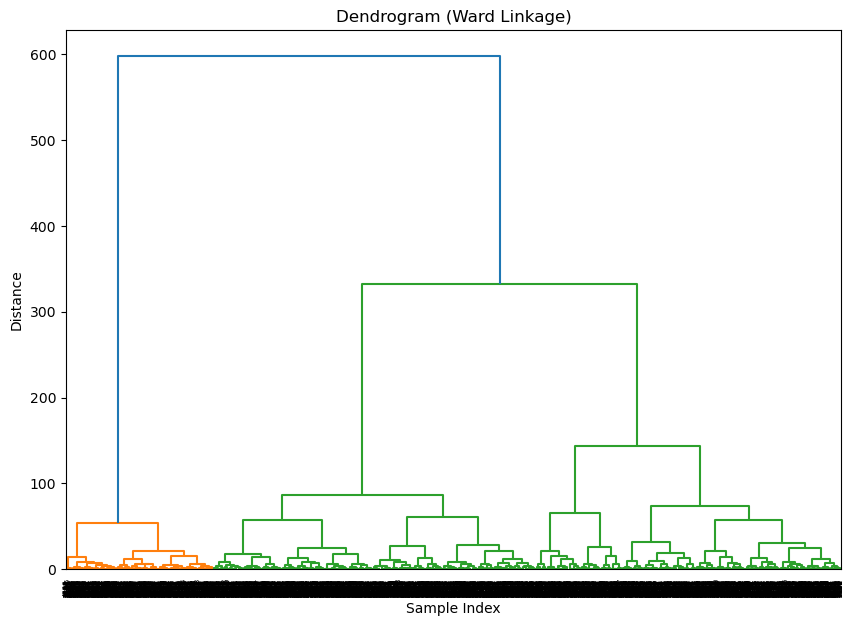

Hierarchical Clustering - Training Data Metrics:
Silhouette Score: 0.60
Calinski-Harabasz Index: 18387.40
Davies-Bouldin Index: 0.63
Adjusted Rand Index: 0.16

Hierarchical Clustering - Test Data Metrics:
Silhouette Score: 0.61
Calinski-Harabasz Index: 4909.44
Davies-Bouldin Index: 0.62
Adjusted Rand Index: 0.17


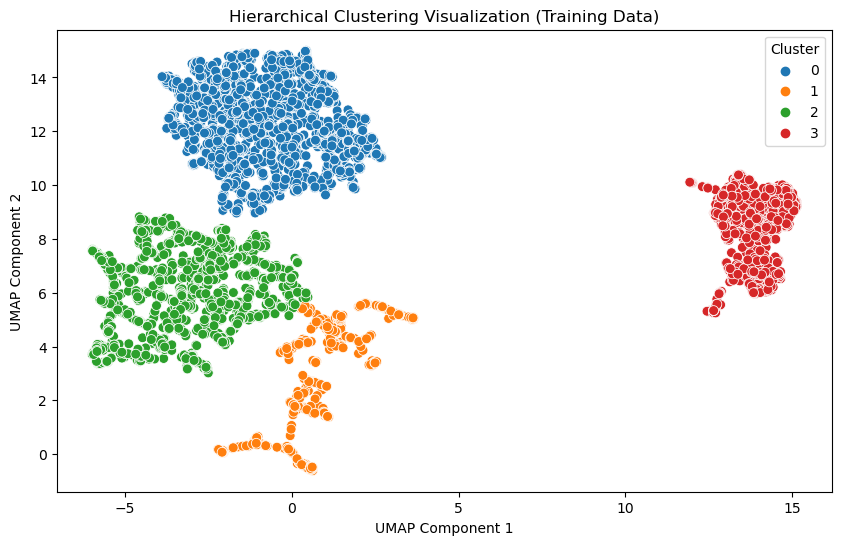

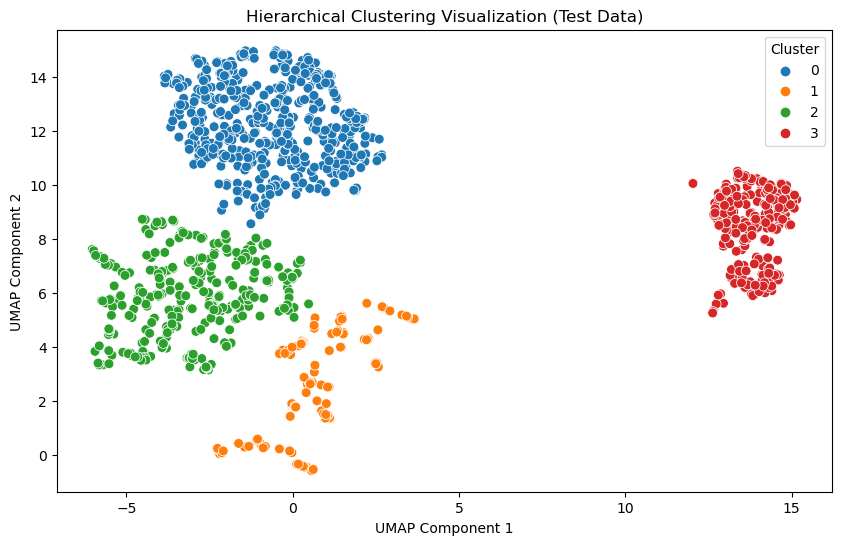

In [6]:
from sklearn.metrics import rand_score, adjusted_rand_score, mutual_info_score, v_measure_score
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import umap

# Load the dataset
data = pd.read_csv('cleaned_train.csv')

# Step 1: Filter out "Adult" category
data = data[data['age_group'] != 'Adult']

# Step 2: Ordinal encode the 'age_group' column
ordinal_encoder = OrdinalEncoder(categories=[['Child', 'Early Teen', 'Teen', 'Young Adult']])
data['age_group'] = ordinal_encoder.fit_transform(data[['age_group']])

# Drop unnecessary columns
columns_to_drop = ['id', 'sii']  # Remove unnecessary columns
data_numeric = data.drop(columns=columns_to_drop, axis=1)

# Split into features and target
X = data_numeric
y = data['sii']  # Use 'sii' for oversampling

# Step 3: Apply ADASYN for Oversampling
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Step 4: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Step 5: UMAP for Dimensionality Reduction
umap_model = umap.UMAP(n_components=2, random_state=42)  # Reduce to 2 components
X_train_umap = umap_model.fit_transform(X_train)
X_test_umap = umap_model.transform(X_test)  # Apply the same transformation to test data

# Step 6: Perform Hierarchical Clustering
# Compute the linkage matrix for dendrogram visualization
linkage_matrix = linkage(X_train_umap, method='ward')  # 'ward' minimizes the variance within clusters

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Dendrogram (Ward Linkage)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Determine the optimal number of clusters visually from the dendrogram or programmatically
optimal_clusters = 4  # You can adjust this based on the dendrogram

# Fit Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=optimal_clusters, affinity='euclidean', linkage='ward')
agg_clusters_train = agg_clustering.fit_predict(X_train_umap)
agg_clusters_test = agg_clustering.fit_predict(X_test_umap)

# Step 7: Evaluate Clustering Performance for Hierarchical Clustering
# Metrics for Training Data
agg_train_silhouette = silhouette_score(X_train_umap, agg_clusters_train)
agg_train_calinski_harabasz = calinski_harabasz_score(X_train_umap, agg_clusters_train)
agg_train_davies_bouldin = davies_bouldin_score(X_train_umap, agg_clusters_train)
agg_train_adjusted_rand_index = adjusted_rand_score(y_train, agg_clusters_train)

# Metrics for Test Data
agg_test_silhouette = silhouette_score(X_test_umap, agg_clusters_test)
agg_test_calinski_harabasz = calinski_harabasz_score(X_test_umap, agg_clusters_test)
agg_test_davies_bouldin = davies_bouldin_score(X_test_umap, agg_clusters_test)
agg_test_adjusted_rand_index = adjusted_rand_score(y_test, agg_clusters_test)

# Print Metrics for Training Data
print(f"Hierarchical Clustering - Training Data Metrics:")
print(f"Silhouette Score: {agg_train_silhouette:.2f}")
print(f"Calinski-Harabasz Index: {agg_train_calinski_harabasz:.2f}")
print(f"Davies-Bouldin Index: {agg_train_davies_bouldin:.2f}")
print(f"Adjusted Rand Index: {agg_train_adjusted_rand_index:.2f}")

# Print Metrics for Test Data
print(f"\nHierarchical Clustering - Test Data Metrics:")
print(f"Silhouette Score: {agg_test_silhouette:.2f}")
print(f"Calinski-Harabasz Index: {agg_test_calinski_harabasz:.2f}")
print(f"Davies-Bouldin Index: {agg_test_davies_bouldin:.2f}")
print(f"Adjusted Rand Index: {agg_test_adjusted_rand_index:.2f}")

# Step 8: Visualize Clusters for Training and Test Data
# Visualization for Training Data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_umap[:, 0], y=X_train_umap[:, 1], hue=agg_clusters_train, palette='tab10', s=50)
plt.title('Hierarchical Clustering Visualization (Training Data)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster')
plt.show()

# Visualization for Test Data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_umap[:, 0], y=X_test_umap[:, 1], hue=agg_clusters_test, palette='tab10', s=50)
plt.title('Hierarchical Clustering Visualization (Test Data)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster')
plt.show()
